# Area of prediction -test-

This notebook develops the method for a morphological analysis of urban blocks that define the area of prediction for the urban land use prediction model.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import momepy as mp
from shapely import wkt

import seaborn as sns
import matplotlib.pyplot as plt 

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Data download/read and preprocessing

### Area of analysis

In [2]:
aoa_gdf = gpd.read_file("../../data/processed/prediccion_uso_suelo/Distrito/distrito.shp")
print(aoa_gdf.shape)
aoa_gdf.head(2)

(1, 2)


,id,geometry
0,1,"POLYGON ((-103.4233 20.91026, -103.42209 20.91..."


In [3]:
aoa_gdf = aoa_gdf.to_crs("EPSG:32613")

<Axes: >

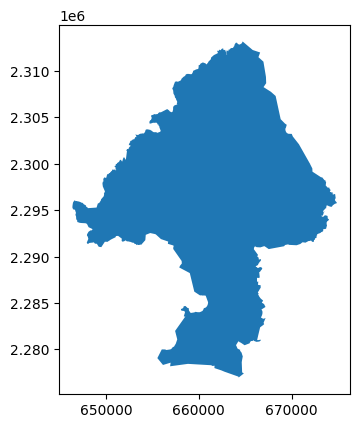

In [4]:
aoa_gdf.plot()

### Buildings footprints

In [5]:
bld_gdf = pd.read_csv('../../data/processed/prediccion_uso_suelo/843_buildings.csv')
bld_gdf['geometry'] = bld_gdf['geometry'].apply(wkt.loads)
bld_gdf = gpd.GeoDataFrame(bld_gdf, crs='epsg:4326')
bld_gdf = bld_gdf.to_crs("EPSG:32613")
print(bld_gdf.shape)
bld_gdf.head(2)

(17536895, 6)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code
0,18.364032,-100.670645,60.4298,0.8018,"POLYGON ((957724.317 2035917.636, 957716.543 2...",75CX987H+JP97
1,20.446907,-103.526685,10.5973,0.7524,"POLYGON ((653691.558 2261626.324, 653691.012 2...",75GRCFWF+Q886


Filter data

In [6]:
bld_clip = gpd.clip(bld_gdf, aoa_gdf)
bld_gdf = bld_gdf.loc[bld_gdf.full_plus_code.isin(list(bld_clip.full_plus_code.unique()))].copy()
print(bld_gdf.shape)
bld_gdf.head(2)

(743937, 6)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code
62,20.689225,-103.450063,15.1462,0.7894,"POLYGON ((661430.451 2288523.131, 661431.347 2...",75GRMGQX+MXV5
63,20.738866,-103.348038,20.5090,0.6686,"POLYGON ((672003.8 2294127.876, 671999.899 229...",75GRPMQ2+GQWQ


Dissolve overlaping buildings

In [7]:
# dismiss dissolve to avoid merging continous buildings
# bld_gdf = bld_gdf.dissolve().explode()
# print(bld_gdf.shape)
# bld_gdf.head(2)

<Axes: >

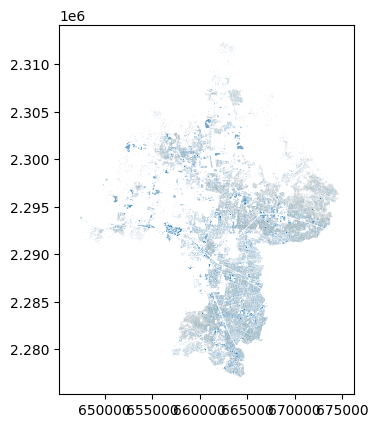

In [8]:
bld_gdf.plot()

### Land use data

In [9]:
use_gdf = gpd.read_file('../../data/processed/prediccion_uso_suelo/Predios_Completos/predios_zapopan_ppdu24.gpkg')
use_gdf = use_gdf[['gid','id','shape_area','uso_suelo','geometry']].copy()
print(use_gdf.shape)
use_gdf.head(2)

(467839, 5)


,gid,id,shape_area,uso_suelo,geometry
0,119895,95475.0,130.922608,Habitacional,"MULTIPOLYGON (((672237.33 2295207.029, 672235...."
1,119896,471562.0,112.073148,Habitacional,"MULTIPOLYGON (((669537.234 2295451.983, 669520..."


In [10]:
use_gdf.uso_suelo.unique()

array(['Habitacional', 'Mixto', 'Baldio', 'Sin dato', 'Espacio verde',
       'Agropecuario', 'Comercio', 'Equipamiento', 'Industria',
       'Infraestructura', 'Servicio', 'Area natural',
       'Alojamiento temporal', 'Area libre', 'Otros'], dtype=object)

### Block data

In [11]:
poly_wkt = aoa_gdf.to_crs("EPSG:4326").dissolve().geometry.to_wkt()[0]

In [12]:
schema = 'marco'
table = 'mza_2020'
query = f"SELECT * FROM {schema}.{table} WHERE ST_Intersects(geometry, 'SRID=4326;{poly_wkt}')"
block_gdf = aup.gdf_from_query(query, geometry_col='geometry')
print(block_gdf.shape)
block_gdf.head(2)

(16273, 9)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
0,1412000012115061,14,120,0001,2115,061,Urbana,Típica,"POLYGON ((-103.32731 20.75711, -103.32734 20.7..."
1,1412000013791052,14,120,0001,3791,052,Urbana,Típica,"POLYGON ((-103.32884 20.76806, -103.32881 20.7..."


## Create prediction area

### Filter buildings by blocks

In [13]:
block_gdf = block_gdf.to_crs("EPSG:32613")
block_gdf = block_gdf[['CVEGEO','geometry']].copy()

In [14]:
bld_block = gpd.overlay(bld_gdf, block_gdf, how='intersection')
print(bld_block.shape)
bld_block.head(2)

(708211, 7)


,latitude,longitude,area_in_meters,confidence,full_plus_code,CVEGEO,geometry
0,20.689225,-103.450063,15.1462,0.7894,75GRMGQX+MXV5,1412000011206018,"POLYGON ((661426.815 2288523.955, 661427.711 2..."
1,20.738866,-103.348038,20.5090,0.6686,75GRPMQ2+GQWQ,1412000010937015,"POLYGON ((672002.649 2294122.899, 671998.749 2..."


### Building morphology

Morphology analysis for each building within it's respective urban block.

In [15]:
def fix_overlapping_bld(gdf):
    # intersect buildings with themsleves
    bld_int = gdf[['full_plus_code','geometry']].overlay(gdf[['full_plus_code','geometry']],
                                                         how='intersection', keep_geom_type=True)
    # count the number of intersections per building
    bld_counter = bld_int.groupby('full_plus_code_1').count()
    # filter building with at least two overlaps
    bld_counter = bld_counter.loc[bld_counter.geometry>=2].reset_index()

    processed_int = [] # save processed buildings to avoid duplicates

    for code_1 in bld_counter.full_plus_code_1:
        # identify buildings to be processed
        bld_int_list = [code_1]
        # gather the code of the buildings that overlap with code_1
        bld_int_list.extend(list(bld_int.loc[bld_int.full_plus_code_1==code_1].full_plus_code_2))
        bld_int_list = list(set(bld_int_list)) # remove duplicate values

        # recalculate area
        gdf['area_m2'] = gdf.area

        # filter complete buildings from original GeoDataFrame
        bld_tmp = gdf.loc[gdf.full_plus_code.isin(bld_int_list)].copy()

        # sort values so largest area is first
        bld_tmp = bld_tmp.sort_values('area_m2', ascending=False)
        bld_tmp = bld_tmp.reset_index()
    
        # always select the bigger area
        bld_diff = bld_tmp.loc[bld_tmp.index==0]
        code_int_1 = bld_tmp.loc[0,'full_plus_code']
    
        # iterate over smaller overlapping areas
        for i,_ in bld_tmp.loc[bld_tmp.index!=0].iterrows():
            code_int_2 = bld_tmp.loc[0,'full_plus_code']

            # check if buildings where previously processed
            if code_int_1+'-'+code_int_2 in processed_int:
                continue
    
            # if buildings haven't been processed analyze the case
            processed_int.append(code_int_1+'-'+code_int_2)
            processed_int.append(code_int_2+'-'+code_int_1)
    
            # calculate geometric difference
            geom_diff = bld_tmp.loc[bld_tmp.index==i].difference(bld_diff, align=False)
            gdf.loc[gdf.full_plus_code==code_int_2, 'geometry'] = geom_diff
            gdf['area_m2'] = gdf.area

    return gdf

**WARNING** parallel processing

In [16]:
from joblib import Parallel, delayed
from tqdm import tqdm

In [17]:
parallel_processing = True

In [18]:
def building_tesselation(cvegeo, block_gdf, bld_block):
    """Process all buildings for a single block"""
    bld_filter = bld_block.loc[bld_block.CVEGEO == cvegeo].copy()
    block_filter = block_gdf.loc[block_gdf.CVEGEO == cvegeo].copy()
    
    # skip if there aren't any buildings for that specific block
    if bld_filter.empty:
        return None
    
    # check if buildings overlap
    gdf_int = bld_filter[['full_plus_code','geometry']].overlay(
        bld_filter[['full_plus_code','geometry']],
        how='intersection', 
        keep_geom_type=True
    )
    
    # if buildings overlap, use fix function
    if len(gdf_int) > len(bld_filter):
        bld_filter = fix_overlapping_bld(bld_filter)
        
    try:  
        tess_tmp = mp.morphological_tessellation(bld_filter, clip=block_filter)
    except:
        return None
    
    # assign block's geographic code
    tess_tmp['CVEGEO'] = cvegeo
    
    # transfer code and building area data
    tess_tmp = tess_tmp.reset_index().rename(columns={'index':'fid'})
    bld_filter = bld_filter[['full_plus_code','area_in_meters']].reset_index().rename(columns={'index':'fid'}).copy()
    tess_tmp = tess_tmp.merge(bld_filter, on=['fid'])
    tess_tmp = tess_tmp.drop(columns=['fid'])
    
    return tess_tmp


In [19]:
if parallel_processing:
    # Execute in parallel

    # Get unique CVEGEOs to process
    unique_cvegeos = bld_block.CVEGEO.unique()
    
    # Execute in parallel - FIXED: Remove extra brackets and pass correct parameters
    results = Parallel(n_jobs=20, verbose=1)(
        delayed(building_tesselation)(cvegeo, block_gdf, bld_block)
        for cvegeo in tqdm(unique_cvegeos, desc="Processing blocks")
    )
    
    print("Processing complete!")

Processing blocks:  43%|██████████████████████████████████████▎                                                   | 6720/15767 [59:28<1:22:31,  1.83it/s]/home/edgaregurrola/.cache/pypoetry/virtualenvs/aup-qDsIK5d5-py3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Processing blocks:  87%|█████████████████████████████████████████████████████████████████████████████▍           | 13721/15767 [2:02:30<18:16,  1.87it/s]/home/edgaregurrola/.cache/pypoetry/virtualenvs/aup-qDsIK5d5-py3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Processing blocks:  90%|████████████████████████████████████████████████████████████

Processing complete!


[Parallel(n_jobs=20)]: Done 15767 out of 15767 | elapsed: 141.5min finished


In [20]:
# Filter out None results and concatenate all DataFrames
valid_results = [result for result in results if result is not None]
tess_gdf = pd.concat(valid_results, ignore_index=True)

print(tess_gdf.shape)
tess_gdf.head(2)

(308288, 4)


,geometry,CVEGEO,full_plus_code,area_in_meters
0,"POLYGON ((661480.037 2288622.628, 661479.654 2...",1412000011206018,75GRMHR2+458V,173.7348
1,"POLYGON ((661363.319 2288734.274, 661362.934 2...",1412000011206018,75GRMGRX+GQP3,81.7922


Single processing

In [21]:
if not parallel_processing:
    
    tess_gdf = gpd.GeoDataFrame()
    
    for cvegeo in bld_block.CVEGEO.unique():
        bld_filter = bld_block.loc[bld_block.CVEGEO==cvegeo].copy()
        block_filter = block_gdf.loc[block_gdf.CVEGEO==cvegeo].copy()
    
        # skip if there aren't any buildings for that specific block
        if bld_filter.empty:
            continue
    
        # check if buildings overlap
        gdf_int = bld_filter[['full_plus_code','geometry']].overlay(bld_filter[['full_plus_code','geometry']],
                                                             how='intersection', keep_geom_type=True)
        # if buildings overlap, use fix function
        if len(gdf_int) > len(bld_filter):
            
            bld_filter = fix_overlapping_bld(bld_filter)
            
        try:  
            tess_tmp = mp.morphological_tessellation(bld_filter, clip=block_filter)
        except:
            continue
        
        # assign block's geographic code
        tess_tmp['CVEGEO'] = cvegeo
    
        # transfer code and building area data
        tess_tmp = tess_tmp.reset_index().rename(columns={'index':'fid'})
        bld_filter = bld_filter[['full_plus_code','area_in_meters']].reset_index().rename(columns={'index':'fid'}).copy()
        tess_tmp = tess_tmp.merge(bld_filter, on=['fid'])
        tess_tmp = tess_tmp.drop(columns=['fid'])
    
        # add data to complete GeoDataFrame
        tess_gdf = pd.concat([tess_gdf, tess_tmp])
    
    print(tess_gdf.shape)
    tess_gdf.head(2)

<Axes: >

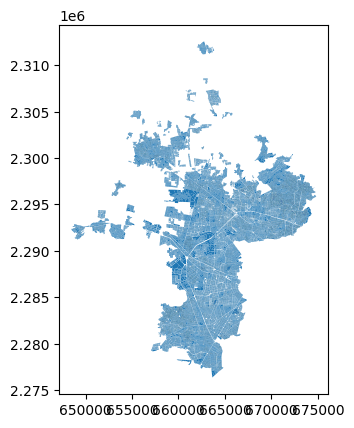

In [21]:
tess_gdf.plot()

### Block area to prediction area

In [22]:
block_gdf['block_area_m2'] = block_gdf.to_crs("EPSG:6372").area
tess_gdf = tess_gdf.merge(block_gdf[['CVEGEO','block_area_m2']],
                         on='CVEGEO')
print(tess_gdf.shape)
tess_gdf.head(2)

(308288, 5)


,geometry,CVEGEO,full_plus_code,area_in_meters,block_area_m2
0,"POLYGON ((661480.037 2288622.628, 661479.654 2...",1412000011206018,75GRMHR2+458V,173.7348,278416.454431
1,"POLYGON ((661363.319 2288734.274, 661362.934 2...",1412000011206018,75GRMGRX+GQP3,81.7922,278416.454431


## Land use to area of prediction

In [23]:
tess_gdf = tess_gdf.rename(columns={'area_in_meters':'bld_area_m2'})

In [24]:
# fix row numbers
tess_gdf = tess_gdf.reset_index(drop=True).reset_index().rename(columns={'index':'fid'})
tess_gdf.head(1)

,fid,geometry,CVEGEO,full_plus_code,bld_area_m2,block_area_m2
0,0,"POLYGON ((661480.037 2288622.628, 661479.654 2...",1412000011206018,75GRMHR2+458V,173.7348,278416.454431


Spatial intersection

In [26]:
tess_uso = tess_gdf.overlay(use_gdf[['uso_suelo','geometry']], how='intersection')
print(tess_uso.shape)
tess_uso.head(2)

(1243755, 7)


,fid,CVEGEO,full_plus_code,bld_area_m2,block_area_m2,uso_suelo,geometry
0,0,1412000011206018,75GRMHR2+458V,173.7348,278416.454431,Servicio,"POLYGON ((661479.654 2288623.005, 661479.268 2..."
1,0,1412000011206018,75GRMHR2+458V,173.7348,278416.454431,Servicio,"POLYGON ((661454.779 2288647.676, 661454.799 2..."


Identify missing values

In [27]:
tess_uso.loc[tess_uso.uso_suelo.isna()]

,fid,CVEGEO,full_plus_code,bld_area_m2,block_area_m2,uso_suelo,geometry


Remove entire blocks with some missing value

Number of missing blocks: 0 out of: 16273


<Axes: >

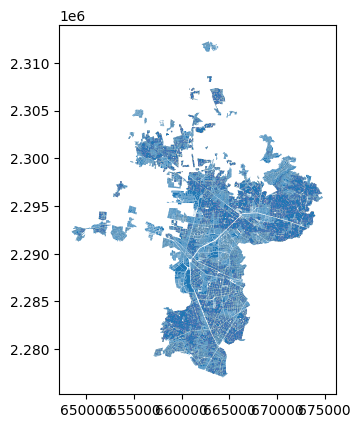

In [29]:
missing_list = list(tess_uso.loc[tess_uso.uso_suelo.isna()].CVEGEO.unique())
print('Number of missing blocks:',len(missing_list),'out of:',len(block_gdf))
tess_uso = tess_uso.loc[~tess_uso.CVEGEO.isin(missing_list)].copy()
tess_uso.plot()

Filter majority use by area of prediction

In [30]:
tess_uso['area_m2'] = tess_uso.area

In [31]:
tess_uso = tess_uso.groupby(['fid','uso_suelo']).sum(numeric_only=True).reset_index()
tess_uso = tess_uso.drop(columns=['bld_area_m2','block_area_m2'])
tess_uso = tess_uso.sort_values(by=['fid','area_m2'],ascending=False).groupby('fid').first()
print(tess_uso.shape)
tess_uso.head(4)

(306992, 2)


,uso_suelo,area_m2
fid,,
0,Servicio,2257.817773
1,Sin dato,711.098560
2,Sin dato,170.594374
3,Sin dato,435.127361


Add geometry

In [32]:
tess_uso = tess_uso.merge(tess_gdf[['fid','full_plus_code',
                                    'CVEGEO','bld_area_m2',
                                    'block_area_m2','geometry']],
                         on='fid')
# convert to GeoDataFrame
tess_uso = gpd.GeoDataFrame(tess_uso)
tess_uso = tess_uso.set_crs("EPSG:32613")

# update area
tess_uso['area_m2'] = tess_uso.area
tess_uso['pred_area_pct'] = tess_uso['area_m2'] / tess_uso['block_area_m2']

print(tess_uso.shape)
tess_uso.head(2)

(306992, 9)


,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,geometry,pred_area_pct
0,0,Servicio,2747.599834,75GRMHR2+458V,1412000011206018,173.7348,278416.454431,"POLYGON ((661480.037 2288622.628, 661479.654 2...",0.009869
1,1,Sin dato,900.765482,75GRMGRX+GQP3,1412000011206018,81.7922,278416.454431,"POLYGON ((661363.319 2288734.274, 661362.934 2...",0.003235


<Axes: >

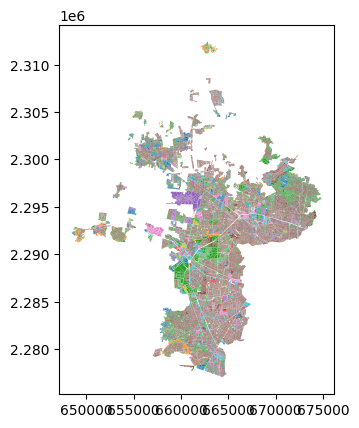

In [33]:
tess_uso.plot('uso_suelo')

Save data

In [34]:
tess_uso.to_file('../../data/processed/prediccion_uso_suelo/tess_uso.geojson')